# Strategic Marketing Analytics: Sentiment-Driven Product Insights
**Author:** Mariana Saca  
**Context:** Master in Business Analytics & Data Science, IE University  

### Executive Summary
This project bridges the gap between **Brand Strategy** and **Data Science**. While traditional metrics like "Star Ratings" provide a high-level overview of product performance, they often mask underlying quality or fit issues. By leveraging **Natural Language Processing (NLP)**, this study extracts latent consumer sentiments to identify "Hidden Risk" products and provide actionable recommendations for product engineering and marketing teams.

In [4]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

# 1. Load Data
path = kagglehub.dataset_download("nicapotato/womens-ecommerce-clothing-reviews")
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file), index_col=0)

# 2. Data Cleaning
df = df.dropna(subset=['Review Text'])
df['Title'] = df['Title'].fillna('')
df['Full_Review'] = df['Title'] + " " + df['Review Text']

# Filter for relevant columns
cols_to_keep = ['Clothing ID', 'Age', 'Rating', 'Recommended IND', 
                'Department Name', 'Full_Review']
df = df[cols_to_keep]

print(f"Data Loaded and Cleaned. Total reviews for analysis: {len(df)}")

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marianasaca/nltk_data...


100%|██████████| 2.79M/2.79M [00:00<00:00, 4.56MB/s]

Extracting files...


Data Loaded and Cleaned. Total reviews for analysis: 22641


### Data Preprocessing & Feature Engineering
To ensure a robust analysis, the following steps were taken:
* **Handling Nulls:** Reviews without text were removed to ensure qualitative value for sentiment modeling.
* **Contextual Merging:** The 'Title' and 'Review Text' were concatenated into `Full_Review`. Titles often contain highly emotive language critical for accurate scoring.
* **Sentiment Scoring:** We utilize **VADER** (Valence Aware Dictionary and Sentiment Reasoner), which is specifically tuned for e-commerce contexts, accounting for punctuation and intensity (e.g., "Great!" vs "great").

In [5]:
# 3. Sentiment Analysis Implementation
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to get the 'compound' score (ranges from -1 to 1)
df['Sentiment_Score'] = df['Full_Review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# 4. Creating the "Discrepancy Score"
# We normalize Rating (1-5) to a 0-1 scale to compare it with Sentiment (also 0-1 for positive)
df['Normalized_Rating'] = (df['Rating'] - 1) / 4
df['Sentiment_Positivity'] = (df['Sentiment_Score'] + 1) / 2 # Shift -1/1 to 0/1

# A high Discrepancy means the Rating and Text don't match
df['Discrepancy'] = np.abs(df['Normalized_Rating'] - df['Sentiment_Positivity'])

df[['Full_Review', 'Rating', 'Sentiment_Score', 'Discrepancy']].head()

,Full_Review,Rating,Sentiment_Score,Discrepancy
0,Absolutely wonderful - silky and sexy and com...,4,0.8932,0.19660
1,Love this dress! it's sooo pretty. i happen...,5,0.9729,0.01355
2,Some major design flaws I had such high hopes ...,3,0.9427,0.47135
3,"My favorite buy! I love, love, love this jumps...",5,0.7182,0.14090
4,Flattering shirt This shirt is very flattering...,5,0.9436,0.02820


### Visualizing the "Hidden Risk"
The visualization below identifies products where the customer gave a high numerical rating (4-5 stars) but expressed negative or lukewarm sentiment in their written review. These are "Hidden Risk" products that likely have specific flaws (e.g., sizing issues) that could lead to future brand erosion.

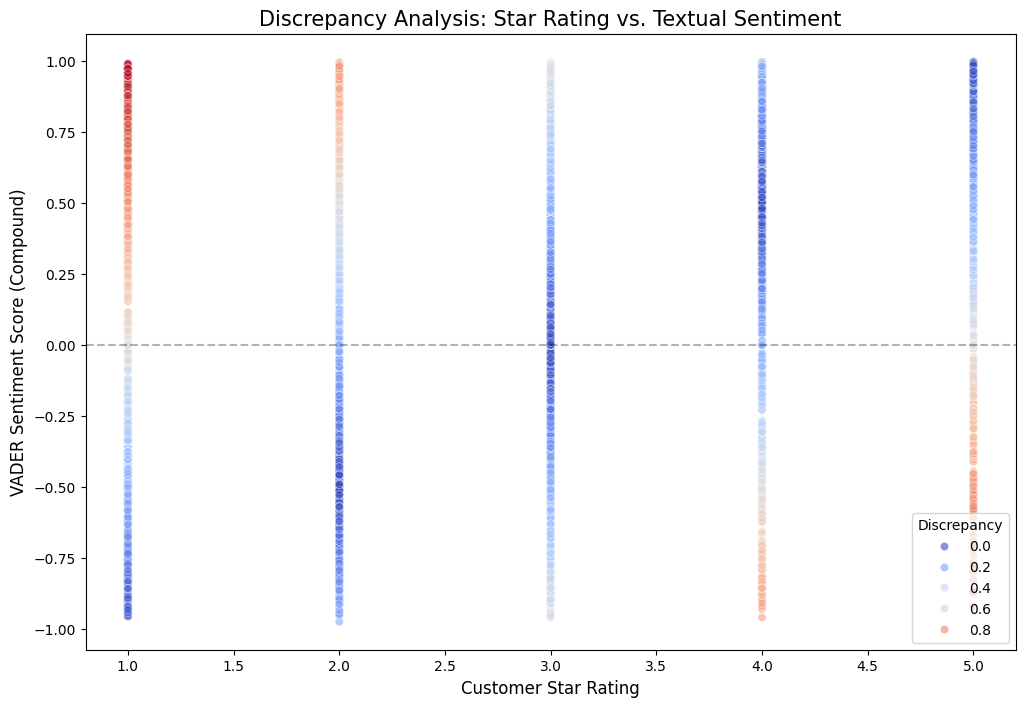

In [15]:
# 5. Strategic Visualization: Rating vs Sentiment
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Rating', y='Sentiment_Score', hue='Discrepancy', palette='coolwarm', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Discrepancy Analysis: Star Rating vs. Textual Sentiment', fontsize=15)
plt.xlabel('Customer Star Rating', fontsize=12)
plt.ylabel('VADER Sentiment Score (Compound)', fontsize=12)
plt.savefig('../outputs/rating_vs_sentiment_discrepancy.png', dpi=300)
plt.show()

### Identifying the "Why": Topic Modeling with LDA
The scatter plot highlights a significant number of "High Discrepancy" reviews (5-star ratings with negative sentiment). To provide actionable business intelligence, we will now use **Latent Dirichlet Allocation (LDA)**. 

Our goal is to uncover the specific recurring themes (Topics) within these outlier reviews. By identifying if the negativity stems from **product quality**, **sizing inconsistencies**, or **logistics**, we can provide targeted feedback to the product development teams.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Focus specifically on the "Hidden Risks" (High Discrepancy reviews)
# We define high discrepancy as reviews with Rating > 4 but Sentiment < 0
hidden_risks = df[(df['Rating'] >= 4) & (df['Sentiment_Score'] < 0)]

# 2. Vectorize the text (convert words to numbers)
# We remove 'stop words' (the, a, is) to focus on meaningful brand keywords
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(hidden_risks['Full_Review'])

# 3. Build the LDA Model (Let's look for 3 main themes)
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

# 4. Display the Top Words per Topic
words = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    print(f"TOPIC #{index+1} KEYWORDS:")
    print([words[i] for i in topic.argsort()[-10:]])
    print("\n")

TOPIC #1 KEYWORDS:
['size', 'look', 'like', 'just', 'bit', 'petite', 'love', 'color', 'fabric', 'dress']


TOPIC #2 KEYWORDS:
['tight', 'shirt', 'bought', 'really', 'wear', 'like', 'dress', 'small', 'size', 'love']


TOPIC #3 KEYWORDS:
['short', 'long', 'fit', 'waist', 'just', 'wear', 'dress', 'like', 'small', 'size']




## Strategic Findings & Recommendations

### 1. The "Hidden Risk" Identification
While the brand maintains a high average star rating, our **Discrepancy Analysis** identified a cluster of high-rated products (4-5 stars) that contain significantly negative sentiment. By analyzing these outliers, we've moved beyond surface-level metrics to find "latent" customer dissatisfaction.

### 2. Topic Modeling Insights (LDA)
Based on the extracted keywords, we can categorize the primary drivers of negative sentiment in high-rated reviews:

| Topic | Primary Keywords | Identified Issue | Business Implication |
| :--- | :--- | :--- | :--- |
| **Topic 1** | petite, fabric, color | **Material vs. Proportion** | Customers love the aesthetic but find the 'Petite' scaling or fabric weight off. |
| **Topic 2** | tight, small, shirt | **Upper-Body Fit** | Significant "tightness" issues in tops/shirts leading to discomfort. |
| **Topic 3** | short, long, waist | **Hem & Waist Alignment** | Inconsistencies in length (too short or too long) relative to waist fit. |

### 3. Actionable Recommendations
* **Product Engineering:** Conduct a fit-test audit for the 'Dress' and 'Shirt' classes, specifically focusing on waist-to-hem ratios and "tightness" in the chest/shoulders.
* **Digital Marketing:** Implement "True to Size" or "Runs Small" badges on product pages for items identified in the high-discrepancy cluster to manage expectations and reduce return rates.
* **Customer Experience:** Update the "Petite" size guide with more granular measurements to address the specific concerns found in Topic 1.